<a href="https://colab.research.google.com/github/Pandu98-pkh/UAS-Deep-Learning/blob/main/Chapter%2018%20Reinforcement%20Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 18: Reinforcement Learning
# Reinforcement Learning

## Pengantar

Reinforcement Learning (RL) adalah paradigma machine learning yang berbeda dari
supervised dan unsupervised learning. Dalam RL, agent belajar melalui interaksi
dengan environment untuk memaksimalkan reward.

**Konsep Kunci:**
- **Agent**: Yang membuat keputusan
- **Environment**: Dunia tempat agent beroperasi
- **State**: Situasi current dari environment
- **Action**: Pilihan yang bisa diambil agent
- **Reward**: Feedback dari environment
- **Policy**: Strategi agent dalam memilih action

**Aplikasi:**
- Game playing (AlphaGo, OpenAI Five)
- Robotics
- Autonomous vehicles
- Trading algorithms
- Resource allocation
- Recommendation systems

In [1]:
# Setup dan Import Libraries untuk Reinforcement Learning
import numpy as np
import tensorflow as tf
import keras
from keras import layers, Model, Input, optimizers, losses, metrics
import matplotlib.pyplot as plt
import gymnasium as gym
from collections import deque
import random
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("Gymnasium version:", gym.__version__)

# Set plot style
plt.style.use('default')
sns.set_palette("husl")

TensorFlow version: 2.18.0
Keras version: 3.8.0
Gymnasium version: 1.1.1


## Mengapa RL Penting?

Reinforcement Learning adalah paradigma pembelajaran di mana seorang **agent** (agen) belajar mengambil **actions** (tindakan) dalam suatu **environment** (lingkungan) untuk memaksimalkan **rewards** (hadiah) yang diterima. Konsep ini terinspirasi dari cara manusia dan hewan belajar melalui trial and error.

**Aplikasi Real-World:**
- **Game Playing**: AlphaGo, OpenAI Five, StarCraft II
- **Robotics**: Robot navigation, manipulation, autonomous vehicles
- **Finance**: Trading algorithms, portfolio optimization
- **Healthcare**: Treatment optimization, drug discovery
- **Recommendation Systems**: Personalized content delivery
- **Resource Management**: Cloud computing, energy optimization

**Perbedaan dengan Supervised Learning:**
- **No labels**: Agent harus menemukan strategy sendiri
- **Sequential decision making**: Actions mempengaruhi future states
- **Delayed rewards**: Feedback mungkin tidak immediate
- **Exploration vs Exploitation**: Balance antara trying new things vs using known good strategies

## 1. Environment Setup - CartPole

Mari mulai dengan **CartPole environment** dari OpenAI Gym - salah satu environment klasik untuk belajar RL. Tujuannya adalah menjaga pole tetap seimbang di atas cart yang bergerak.

In [2]:
# Setup CartPole Environment
env = gym.make('CartPole-v1')

# Explore environment properties
print("Environment Information:")
print(f"Observation Space: {env.observation_space}")
print(f"Action Space: {env.action_space}")

# Observation space explanation
print("\nObservation Components:")
print("0: Cart Position (-4.8 to 4.8)")
print("1: Cart Velocity (-Inf to Inf)")
print("2: Pole Angle (-0.418 to 0.418 radians, ~24 degrees)")
print("3: Pole Angular Velocity (-Inf to Inf)")

print("\nAction Space:")
print("0: Push cart to the LEFT")
print("1: Push cart to the RIGHT")

# Test environment
print("\nTesting environment...")
obs, info = env.reset()
print(f"Initial observation: {obs}")

for i in range(5):
    action = env.action_space.sample()  # Random action
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    print(f"Step {i+1}: Action={action}, Reward={reward}, Done={done}")
    print(f"  Observation: {obs}")

    if done:
        obs, info = env.reset()
        print("  Episode terminated, environment reset")

Environment Information:
Observation Space: Box([-4.8               -inf -0.41887903        -inf], [4.8               inf 0.41887903        inf], (4,), float32)
Action Space: Discrete(2)

Observation Components:
0: Cart Position (-4.8 to 4.8)
1: Cart Velocity (-Inf to Inf)
2: Pole Angle (-0.418 to 0.418 radians, ~24 degrees)
3: Pole Angular Velocity (-Inf to Inf)

Action Space:
0: Push cart to the LEFT
1: Push cart to the RIGHT

Testing environment...
Initial observation: [0.00947455 0.00038873 0.00640493 0.04648653]
Step 1: Action=1, Reward=1.0, Done=False
  Observation: [ 0.00948232  0.19541825  0.00733466 -0.24416873]
Step 2: Action=1, Reward=1.0, Done=False
  Observation: [ 0.01339069  0.39043468  0.00245128 -0.53452915]
Step 3: Action=0, Reward=1.0, Done=False
  Observation: [ 0.02119938  0.19527835 -0.0082393  -0.24107482]
Step 4: Action=1, Reward=1.0, Done=False
  Observation: [ 0.02510495  0.39051703 -0.01306079 -0.53634524]
Step 5: Action=1, Reward=1.0, Done=False
  Observatio

## 2. Policy Search - Random vs Basic Policies

Sebelum menggunakan algoritma RL yang sophisticated, mari kita mulai dengan policies sederhana untuk memahami baseline performance.

Random Policy Results:
Average reward: 22.30 (+/- 12.03)
Average episode length: 22.30
Best performance: 67.0

Basic Policy Results:
Average reward: 42.45 (+/- 8.89)
Best performance: 67.0


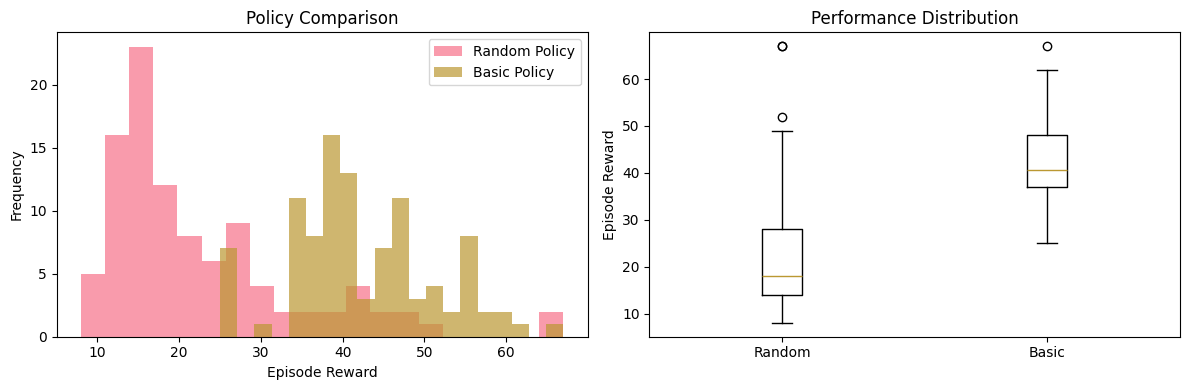

In [3]:
# Random Policy Implementation
def run_random_episode(env):
    """Run single episode dengan random policy"""
    obs, info = env.reset()
    total_reward = 0

    for step in range(200):  # Max 200 steps
        # Random action
        action = env.action_space.sample()

        # Execute action
        obs, reward, terminated, truncated, info = env.step(action)
        done = terminated or truncated
        total_reward += reward

        if done:
            break

    return total_reward, step + 1

# Test random policy
rewards = []
episode_lengths = []

for episode in range(100):
    reward, length = run_random_episode(env)
    rewards.append(reward)
    episode_lengths.append(length)

print(f"Random Policy Results:")
print(f"Average reward: {np.mean(rewards):.2f} (+/- {np.std(rewards):.2f})")
print(f"Average episode length: {np.mean(episode_lengths):.2f}")
print(f"Best performance: {np.max(rewards)}")

# Basic Policy Implementation
def basic_policy(obs):
    """Simple heuristic policy based on pole angle"""
    pole_angle = obs[2]

    # If pole is leaning left, push cart left
    # If pole is leaning right, push cart right
    if pole_angle < 0:
        return 0  # Push left
    else:
        return 1  # Push right

def test_policy(env, policy_func, num_episodes=100):
    """Test policy function"""
    rewards = []

    for episode in range(num_episodes):
        obs, info = env.reset()
        total_reward = 0

        for step in range(200):
            action = policy_func(obs)
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            total_reward += reward

            if done:
                break

        rewards.append(total_reward)

    return rewards

# Test basic policy
basic_rewards = test_policy(env, basic_policy)
print(f"\nBasic Policy Results:")
print(f"Average reward: {np.mean(basic_rewards):.2f} (+/- {np.std(basic_rewards):.2f})")
print(f"Best performance: {np.max(basic_rewards)}")

# Visualize comparison
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(rewards, bins=20, alpha=0.7, label='Random Policy')
plt.hist(basic_rewards, bins=20, alpha=0.7, label='Basic Policy')
plt.xlabel('Episode Reward')
plt.ylabel('Frequency')
plt.title('Policy Comparison')
plt.legend()

plt.subplot(1, 2, 2)
plt.boxplot([rewards, basic_rewards], labels=['Random', 'Basic'])
plt.ylabel('Episode Reward')
plt.title('Performance Distribution')

plt.tight_layout()
plt.show()

## 3. Neural Network Policies

Sekarang mari kita implementasikan policy menggunakan neural network yang dapat belajar dari pengalaman. Ini adalah foundation untuk policy gradient methods.

In [5]:
# Neural Network Policy Implementation
class NeuralNetworkPolicy:
    """Simple neural network policy"""

    def __init__(self, n_inputs=4, n_hidden=5, n_outputs=2):
        self.model = keras.models.Sequential([
            keras.layers.Dense(n_hidden, activation="relu", input_shape=[n_inputs]),
            keras.layers.Dense(n_outputs, activation="softmax")  # Probability distribution over actions
        ])

    def choose_action(self, obs):
        """Choose action based on policy probabilities"""
        obs_batch = obs.reshape(1, -1)
        probabilities = self.model.predict(obs_batch, verbose=0)[0]
        return np.random.choice(len(probabilities), p=probabilities)

# Create neural network policy dengan random weights
nn_policy = NeuralNetworkPolicy(n_inputs=4, n_hidden=5, n_outputs=2)

def test_nn_policy(env, policy, num_episodes=100):
    """Test neural network policy"""
    rewards = []

    for episode in range(num_episodes):
        obs, info = env.reset()  # Get both observation and info
        total_reward = 0

        for step in range(200):
            action = policy.choose_action(obs)
            # The step function now returns 5 values in newer Gymnasium versions
            obs, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated # Check for termination or truncation
            total_reward += reward

            if done:
                break

        rewards.append(total_reward)

    return rewards

# Test dengan random weights
random_nn_rewards = test_nn_policy(env, nn_policy)
print(f"Random NN Policy Results:")
print(f"Average reward: {np.mean(random_nn_rewards):.2f} (+/- {np.std(random_nn_rewards):.2f})")
print(f"Best performance: {np.max(random_nn_rewards)}")

# Visualize neural network architecture
print("\nNeural Network Architecture:")
nn_policy.model.summary()

Random NN Policy Results:
Average reward: 26.36 (+/- 13.52)
Best performance: 84.0

Neural Network Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 5)              │            25 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37 (148.00 B)

 Trainable params: 37 (148.00 B)

 Non-trainable params: 0 (0.00 B)

## 4. Policy Gradients Implementation

### Credit Assignment Problem

Masalah utama dalam RL adalah **credit assignment problem**: ketika agent mendapat reward, sulit menentukan action mana yang berkontribusi terhadap reward tersebut.

**Solusi**: Menggunakan **discounted rewards** dan **advantage estimation**.

Original rewards: [10, 0, -50]
Discounted rewards: [-22 -40 -50]


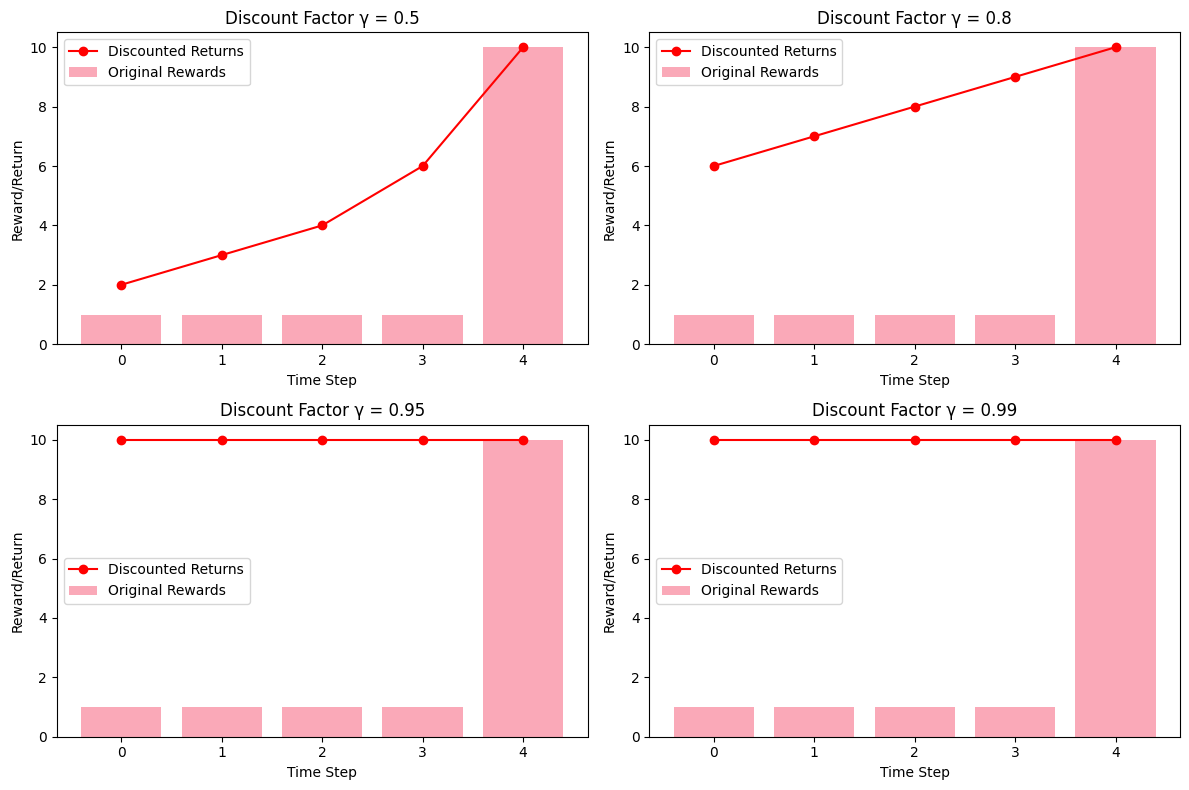


Penjelasan Discounted Rewards:
- Konsep: Action yang dilakukan lebih awal dalam episode memiliki pengaruh lebih besar terhadap outcome
- Formula: R_t = r_t + γ·r_{t+1} + γ²·r_{t+2} + ...
- Discount factor (γ): Menentukan seberapa penting future rewards (0.9-0.99 umumnya)


In [6]:
# Discounted Rewards Implementation
def compute_discounted_rewards(rewards, discount_factor=0.95):
    """
    Compute discounted rewards (returns) untuk setiap timestep

    Args:
        rewards: list of rewards untuk satu episode
        discount_factor: gamma, faktor diskon untuk future rewards

    Returns:
        discounted_rewards: array of discounted returns
    """
    discounted = np.array(rewards)

    # Compute discounted rewards dari belakang
    for i in range(len(rewards) - 2, -1, -1):
        discounted[i] = rewards[i] + discount_factor * discounted[i + 1]

    return discounted

# Test discounted rewards
test_rewards = [10, 0, -50]
discounted = compute_discounted_rewards(test_rewards, discount_factor=0.8)
print(f"Original rewards: {test_rewards}")
print(f"Discounted rewards: {discounted}")

# Visualize effect of different discount factors
rewards_example = [1, 1, 1, 1, 10]  # Small rewards followed by big reward
discount_factors = [0.5, 0.8, 0.95, 0.99]

plt.figure(figsize=(12, 8))
for i, gamma in enumerate(discount_factors):
    discounted_rewards = compute_discounted_rewards(rewards_example, gamma)

    plt.subplot(2, 2, i+1)
    x = range(len(rewards_example))
    plt.bar(x, rewards_example, alpha=0.6, label='Original Rewards')
    plt.plot(x, discounted_rewards, 'ro-', label='Discounted Returns')
    plt.title(f'Discount Factor γ = {gamma}')
    plt.xlabel('Time Step')
    plt.ylabel('Reward/Return')
    plt.legend()

plt.tight_layout()
plt.show()

print("\nPenjelasan Discounted Rewards:")
print("- Konsep: Action yang dilakukan lebih awal dalam episode memiliki pengaruh lebih besar terhadap outcome")
print("- Formula: R_t = r_t + γ·r_{t+1} + γ²·r_{t+2} + ...")
print("- Discount factor (γ): Menentukan seberapa penting future rewards (0.9-0.99 umumnya)")

### REINFORCE Algorithm Implementation

REINFORCE adalah algoritma policy gradient yang sederhana namun powerful. Algoritma ini menggunakan Monte Carlo sampling untuk estimate policy gradient.

In [7]:
# REINFORCE Algorithm Implementation
class REINFORCEAgent:
    """REINFORCE Algorithm untuk Policy Gradient"""

    def __init__(self, n_inputs=4, n_hidden=5, learning_rate=0.01):
        """
        Initialize REINFORCE agent

        Args:
            n_inputs: input dimension (observation space)
            n_hidden: hidden layer size
            learning_rate: learning rate untuk optimizer
        """
        self.n_inputs = n_inputs

        # Build neural network policy
        self.model = keras.models.Sequential([
            keras.layers.Dense(n_hidden, activation="elu", input_shape=[n_inputs]),
            keras.layers.Dense(1, activation="sigmoid")
        ])

        # Optimizer
        self.optimizer = keras.optimizers.Adam(learning_rate=learning_rate)

        # Storage untuk training data
        self.episode_states = []
        self.episode_actions = []
        self.episode_rewards = []

    def choose_action(self, state):
        """Choose action using current policy"""
        state_batch = state.reshape(1, -1)
        prob_left = self.model.predict(state_batch, verbose=0)[0, 0]

        # Sample action berdasarkan probability
        action = 0 if np.random.random() < prob_left else 1

        # Store untuk training
        self.episode_states.append(state)
        self.episode_actions.append(action)

        return action

    def store_reward(self, reward):
        """Store reward untuk current timestep"""
        self.episode_rewards.append(reward)

    def train_episode(self, discount_factor=0.95):
        """Train policy menggunakan data dari satu episode"""
        if len(self.episode_rewards) == 0:
            return

        # Compute discounted rewards
        discounted_rewards = compute_discounted_rewards(
            self.episode_rewards, discount_factor
        )

        # Normalize rewards (advantage estimation)
        discounted_rewards = (discounted_rewards - np.mean(discounted_rewards)) / (
            np.std(discounted_rewards) + 1e-8
        )

        # Convert ke tensors
        states = tf.constant(self.episode_states, dtype=tf.float32)
        actions = tf.constant(self.episode_actions, dtype=tf.float32)
        advantages = tf.constant(discounted_rewards, dtype=tf.float32)

        # Training step
        with tf.GradientTape() as tape:
            # Forward pass
            left_probabilities = self.model(states)[:, 0]

            # Compute action probabilities berdasarkan chosen actions
            action_probabilities = tf.where(
                actions == 0,
                left_probabilities,      # P(left) jika action = 0
                1 - left_probabilities   # P(right) jika action = 1
            )

            # Policy gradient loss
            # Loss = -log(π(a|s)) * A(s,a)
            loss = -tf.reduce_mean(
                tf.math.log(action_probabilities + 1e-8) * advantages
            )

        # Compute gradients dan update weights
        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))

        # Clear episode data
        self.episode_states.clear()
        self.episode_actions.clear()
        self.episode_rewards.clear()

        return loss.numpy()

# Buat REINFORCE agent
agent = REINFORCEAgent(n_inputs=4, n_hidden=5, learning_rate=0.01)

print("REINFORCE Agent created!")
print("Model Architecture:")
agent.model.summary()

REINFORCE Agent created!
Model Architecture:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 5)              │            25 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31 (124.00 B)

 Trainable params: 31 (124.00 B)

 Non-trainable params: 0 (0.00 B)

Training REINFORCE Agent...
Episode 100: Average Reward = 14.98
Episode 200: Average Reward = 22.02
Episode 300: Average Reward = 38.77
Episode 400: Average Reward = 117.06
Episode 500: Average Reward = 175.15


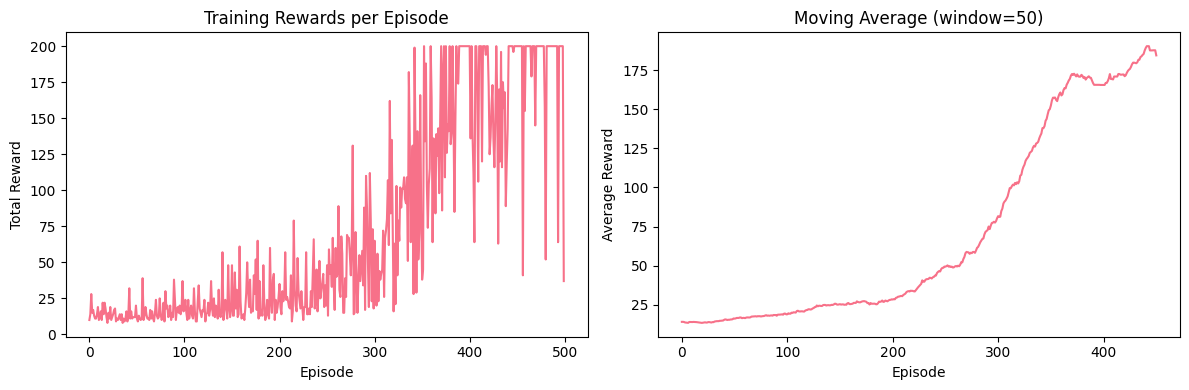


Training completed!
Final 100 episodes average: 175.15

Trained Agent Performance:
Average reward: 200.00 (+/- 0.00)
Best performance: 200.0


In [9]:
# Training REINFORCE Agent
def train_reinforce_agent(env, agent, num_episodes=500, print_every=100):
    """
    Train REINFORCE agent

    Args:
        env: OpenAI Gym environment
        agent: REINFORCEAgent instance
        num_episodes: jumlah training episodes
        print_every: interval untuk print progress

    Returns:
        episode_rewards: list of total rewards per episode
    """
    episode_rewards = []

    for episode in range(num_episodes):
        state, info = env.reset()  # Get both observation and info
        total_reward = 0

        for step in range(200):
            action = agent.choose_action(state)
            # The step function now returns 5 values in newer Gymnasium versions
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated # Check for termination or truncation

            # Store experience
            agent.store_reward(reward)

            total_reward += reward
            state = next_state

            if done:
                break

        # Train agent pada akhir episode
        loss = agent.train_episode()

        episode_rewards.append(total_reward)

        # Print progress
        if (episode + 1) % print_every == 0:
            avg_reward = np.mean(episode_rewards[-print_every:])
            print(f"Episode {episode + 1}: Average Reward = {avg_reward:.2f}")

    return episode_rewards

# Train agent
print("Training REINFORCE Agent...")
training_rewards = train_reinforce_agent(env, agent, num_episodes=500)

# Plot training progress
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(training_rewards)
plt.title("Training Rewards per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")

# Moving average untuk smoothing
window_size = 50
if len(training_rewards) >= window_size:
    moving_avg = np.convolve(training_rewards, np.ones(window_size)/window_size, mode='valid')
    plt.subplot(1, 2, 2)
    plt.plot(moving_avg)
    plt.title(f"Moving Average (window={window_size})")
    plt.xlabel("Episode")
    plt.ylabel("Average Reward")

plt.tight_layout()
plt.show()

print(f"\nTraining completed!")
print(f"Final 100 episodes average: {np.mean(training_rewards[-100:]):.2f}")

# Test trained agent
test_rewards = []
for episode in range(100):
    state, info = env.reset() # Get both observation and info
    total_reward = 0

    for step in range(200):
        # Use policy tanpa exploration (deterministic)
        state_batch = state.reshape(1, -1)
        prob_left = agent.model.predict(state_batch, verbose=0)[0, 0]
        action = 0 if prob_left > 0.5 else 1  # deterministic choice

        next_state, reward, terminated, truncated, info = env.step(action) # Capture all 5 values
        done = terminated or truncated # Check for termination or truncation

        total_reward += reward
        state = next_state

        if done:
            break

    test_rewards.append(total_reward)

print(f"\nTrained Agent Performance:")
print(f"Average reward: {np.mean(test_rewards):.2f} (+/- {np.std(test_rewards):.2f})")
print(f"Best performance: {np.max(test_rewards)}")

## 5. Q-Learning dan Deep Q-Networks (DQN)

### Markov Decision Processes (MDP)

Sebelum membahas Q-Learning, penting memahami **Markov Decision Process** yang merupakan framework matematika untuk RL:

**Komponen MDP:**
- **States (S)**: Himpunan semua possible states
- **Actions (A)**: Himpunan semua possible actions  
- **Transition Probabilities (P)**: P(s'|s,a) - probabilitas transisi ke state s' dari state s dengan action a
- **Rewards (R)**: R(s,a,s') - reward yang diterima untuk transisi tertentu
- **Discount Factor (γ)**: Faktor untuk mengurangi importance future rewards

### Q-Learning Theory

**Q-Function**: Q(s,a) merepresentasikan expected total discounted reward jika mengambil action a di state s dan kemudian mengikuti optimal policy.

**Bellman Equation**: Q*(s,a) = E[r + γ * max Q*(s',a')]

In [10]:
# Deep Q-Network (DQN) Implementation
class DQNAgent:
    """Deep Q-Network Agent"""

    def __init__(self, state_size=4, action_size=2, learning_rate=0.001):
        """
        Initialize DQN agent

        Args:
            state_size: dimensi observation space
            action_size: jumlah possible actions
            learning_rate: learning rate untuk neural network
        """
        self.state_size = state_size
        self.action_size = action_size
        self.lr = learning_rate

        # Hyperparameters
        self.epsilon = 1.0          # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.gamma = 0.95          # discount factor

        # Replay buffer
        self.memory = deque(maxlen=2000)
        self.batch_size = 32

        # Neural network
        self.model = self._build_model()

    def _build_model(self):
        """Build neural network untuk Q-function approximation"""
        model = keras.models.Sequential([
            keras.layers.Dense(32, activation='relu', input_shape=(self.state_size,)),
            keras.layers.Dense(32, activation='relu'),
            keras.layers.Dense(self.action_size, activation='linear')
        ])

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=self.lr),
            loss='mse'
        )

        return model

    def remember(self, state, action, reward, next_state, done):
        """Store experience dalam replay buffer"""
        self.memory.append((state, action, reward, next_state, done))

    def choose_action(self, state):
        """Epsilon-greedy action selection"""
        if np.random.random() <= self.epsilon:
            return np.random.randint(self.action_size)

        q_values = self.model.predict(state.reshape(1, -1), verbose=0)
        return np.argmax(q_values[0])

    def replay(self):
        """Experience replay training"""
        if len(self.memory) < self.batch_size:
            return

        # Sample random batch dari memory
        batch = random.sample(self.memory, self.batch_size)

        states = np.array([experience[0] for experience in batch])
        actions = np.array([experience[1] for experience in batch])
        rewards = np.array([experience[2] for experience in batch])
        next_states = np.array([experience[3] for experience in batch])
        dones = np.array([experience[4] for experience in batch])

        # Current Q-values
        current_q_values = self.model.predict(states, verbose=0)

        # Next Q-values
        next_q_values = self.model.predict(next_states, verbose=0)

        # Update Q-values
        for i in range(self.batch_size):
            if dones[i]:
                current_q_values[i][actions[i]] = rewards[i]
            else:
                current_q_values[i][actions[i]] = rewards[i] + self.gamma * np.max(next_q_values[i])

        # Train model
        self.model.fit(states, current_q_values, epochs=1, verbose=0)

        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Buat DQN agent
dqn_agent = DQNAgent(state_size=4, action_size=2)

print("DQN Agent created!")
print("Model Architecture:")
dqn_agent.model.summary()

DQN Agent created!
Model Architecture:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 32)             │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,282 (5.01 KB)

 Trainable params: 1,282 (5.01 KB)

 Non-trainable params: 0 (0.00 B)

Training DQN Agent...
Episode 100: Average Reward = 19.41, Epsilon = 0.609
Episode 200: Average Reward = 13.76, Epsilon = 0.369
Episode 300: Average Reward = 14.11, Epsilon = 0.223
Episode 400: Average Reward = 35.44, Epsilon = 0.135
Episode 500: Average Reward = 31.89, Epsilon = 0.082


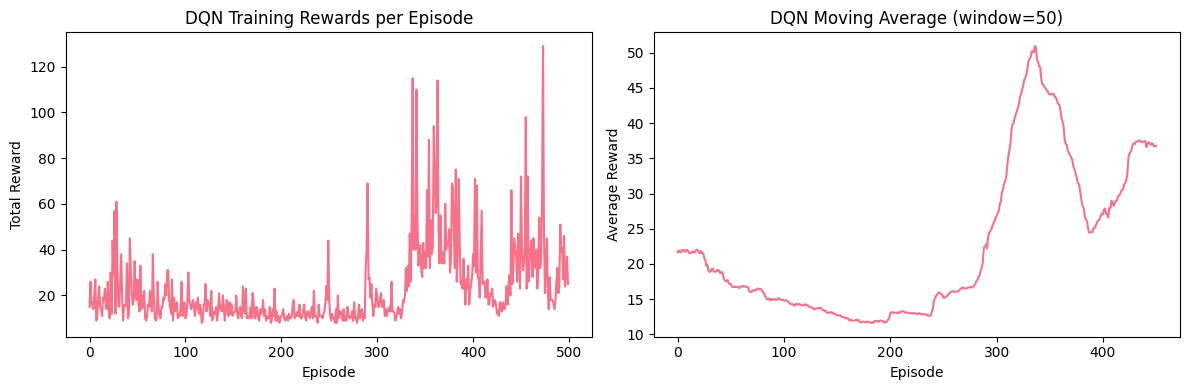


DQN Training completed!
Final 100 episodes average: 31.89
Final epsilon: 0.082


In [12]:
# Training DQN Agent
def train_dqn_agent(env, agent, num_episodes=500, print_every=100):
    """
    Train DQN agent

    Args:
        env: OpenAI Gym environment
        agent: DQNAgent instance
        num_episodes: jumlah training episodes
        print_every: interval untuk print progress

    Returns:
        episode_rewards: list of total rewards per episode
    """
    episode_rewards = []

    for episode in range(num_episodes):
        state, info = env.reset()  # Get both observation and info
        total_reward = 0

        for step in range(200):
            action = agent.choose_action(state)
            # The step function now returns 5 values in newer Gymnasium versions
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated # Check for termination or truncation

            # Store experience
            agent.remember(state, action, reward, next_state, done)

            total_reward += reward
            state = next_state

            if done:
                break

        # Train agent
        if len(agent.memory) > agent.batch_size:
            agent.replay()

        episode_rewards.append(total_reward)

        # Print progress
        if (episode + 1) % print_every == 0:
            avg_reward = np.mean(episode_rewards[-print_every:])
            print(f"Episode {episode + 1}: Average Reward = {avg_reward:.2f}, Epsilon = {agent.epsilon:.3f}")

    return episode_rewards

# Train DQN agent
print("Training DQN Agent...")
dqn_rewards = train_dqn_agent(env, dqn_agent, num_episodes=500)

# Plot DQN training progress
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(dqn_rewards)
plt.title("DQN Training Rewards per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")

# Moving average
window_size = 50
if len(dqn_rewards) >= window_size:
    dqn_moving_avg = np.convolve(dqn_rewards, np.ones(window_size)/window_size, mode='valid')
    plt.subplot(1, 2, 2)
    plt.plot(dqn_moving_avg)
    plt.title(f"DQN Moving Average (window={window_size})")
    plt.xlabel("Episode")
    plt.ylabel("Average Reward")

plt.tight_layout()
plt.show()

print(f"\nDQN Training completed!")
print(f"Final 100 episodes average: {np.mean(dqn_rewards[-100:]):.2f}")
print(f"Final epsilon: {dqn_agent.epsilon:.3f}")

## 6. Performance Evaluation dan Comparison

Mari kita bandingkan performa semua agent yang telah kita implementasikan: Random Policy, Basic Policy, REINFORCE, dan DQN.

Basic Policy Performance:
  Average reward: 42.22 (+/- 8.84)
  Best performance: 63.0
  Success rate (reward >= 195): 0.0%

REINFORCE Performance:
  Average reward: 200.00 (+/- 0.00)
  Best performance: 200.0
  Success rate (reward >= 195): 100.0%

DQN Performance:
  Average reward: 40.35 (+/- 15.07)
  Best performance: 100.0
  Success rate (reward >= 195): 0.0%



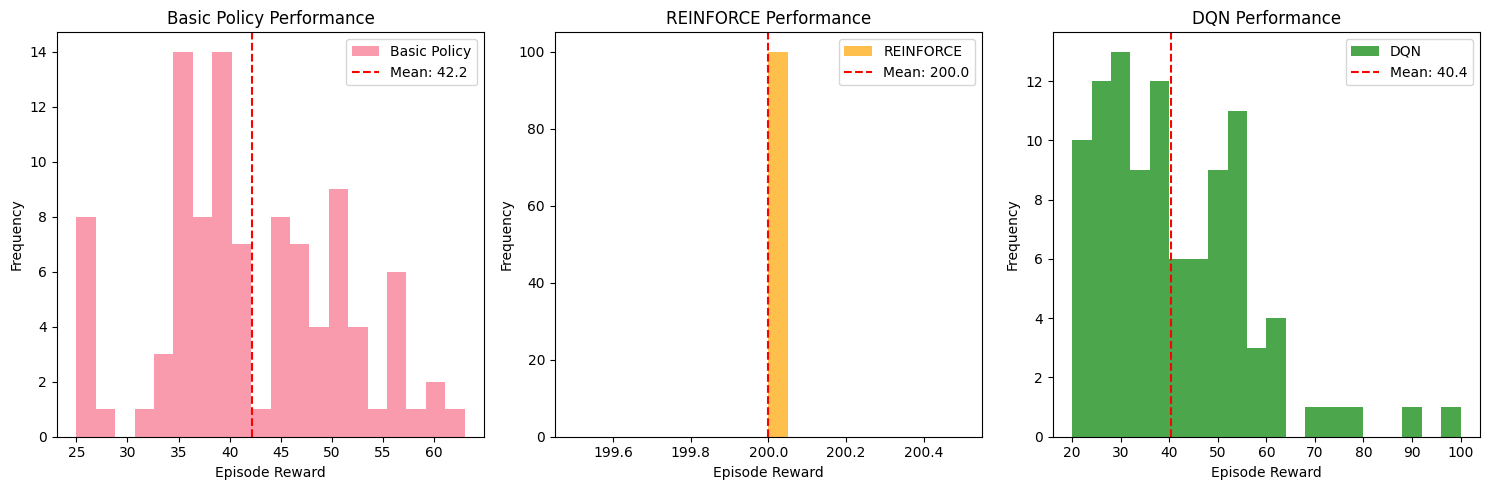

=== PERFORMANCE SUMMARY ===
Random Policy:     22.3 ± 12.0
Basic Policy:      42.2 ± 8.8
REINFORCE:         200.0 ± 0.0
DQN:               40.4 ± 15.1


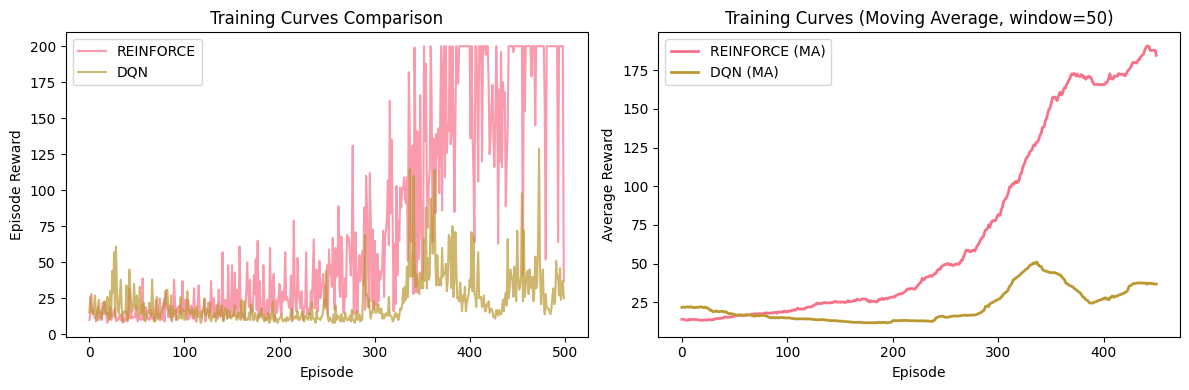

In [14]:
# Performance Evaluation
def test_agent_performance(env, policy_func, num_episodes=100, agent_name="Agent"):
    """Test agent performance dengan policy function"""
    rewards = []

    for episode in range(num_episodes):
        # Reset environment and get the observation and info
        state, info = env.reset()
        total_reward = 0

        for step in range(200):
            # Pass only the state to the policy function
            action = policy_func(state)
            # Get the next state, reward, termination, truncation, and info
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated # Check for termination or truncation
            total_reward += reward

            state = next_state

            if done:
                break

        rewards.append(total_reward)

    print(f"{agent_name} Performance:")
    print(f"  Average reward: {np.mean(rewards):.2f} (+/- {np.std(rewards):.2f})")
    print(f"  Best performance: {np.max(rewards)}")
    # Check if the rewards list is not empty before calculating success rate
    if rewards:
        print(f"  Success rate (reward >= 195): {np.mean(np.array(rewards) >= 195)*100:.1f}%")
    else:
        print("  Success rate: N/A (No episodes completed)")
    print()

    return rewards

# Test basic policy
basic_test_rewards = test_agent_performance(env, basic_policy, agent_name="Basic Policy")

# Test trained REINFORCE agent
def reinforce_policy(state):
    state_batch = state.reshape(1, -1)
    prob_left = agent.model.predict(state_batch, verbose=0)[0, 0]
    return 0 if prob_left > 0.5 else 1

reinforce_test_rewards = test_agent_performance(env, reinforce_policy, agent_name="REINFORCE")

# Test trained DQN agent
def dqn_policy(state):
    q_values = dqn_agent.model.predict(state.reshape(1, -1), verbose=0)
    return np.argmax(q_values[0])

dqn_test_rewards = test_agent_performance(env, dqn_policy, agent_name="DQN")

# Plot comparison
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(basic_test_rewards, bins=20, alpha=0.7, label='Basic Policy')
plt.xlabel('Episode Reward')
plt.ylabel('Frequency')
plt.title('Basic Policy Performance')
plt.axvline(np.mean(basic_test_rewards), color='red', linestyle='--', label=f'Mean: {np.mean(basic_test_rewards):.1f}')
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(reinforce_test_rewards, bins=20, alpha=0.7, label='REINFORCE', color='orange')
plt.xlabel('Episode Reward')
plt.ylabel('Frequency')
plt.title('REINFORCE Performance')
plt.axvline(np.mean(reinforce_test_rewards), color='red', linestyle='--', label=f'Mean: {np.mean(reinforce_test_rewards):.1f}')
plt.legend()

plt.subplot(1, 3, 3)
plt.hist(dqn_test_rewards, bins=20, alpha=0.7, label='DQN', color='green')
plt.xlabel('Episode Reward')
plt.ylabel('Frequency')
plt.title('DQN Performance')
plt.axvline(np.mean(dqn_test_rewards), color='red', linestyle='--', label=f'Mean: {np.mean(dqn_test_rewards):.1f}')
plt.legend()

plt.tight_layout()
plt.show()

# Summary comparison
print("=== PERFORMANCE SUMMARY ===")
# Ensure the 'rewards' variable from the random policy test is still available or re-run that test
# For now, assuming it's available from the code context
try:
    print(f"Random Policy:     {np.mean(rewards):.1f} ± {np.std(rewards):.1f}")
except NameError:
    print("Random Policy:     Results not available. Run the random policy test first.")

print(f"Basic Policy:      {np.mean(basic_test_rewards):.1f} ± {np.std(basic_test_rewards):.1f}")
print(f"REINFORCE:         {np.mean(reinforce_test_rewards):.1f} ± {np.std(reinforce_test_rewards):.1f}")
print(f"DQN:               {np.mean(dqn_test_rewards):.1f} ± {np.std(dqn_test_rewards):.1f}")

# Learning curves comparison
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(training_rewards, label='REINFORCE', alpha=0.7)
plt.plot(dqn_rewards, label='DQN', alpha=0.7)
plt.title('Training Curves Comparison')
plt.xlabel('Episode')
plt.ylabel('Episode Reward')
plt.legend()

plt.subplot(1, 2, 2)
# Moving averages
window_size = 50
if len(training_rewards) >= window_size and len(dqn_rewards) >= window_size:
    reinforce_ma = np.convolve(training_rewards, np.ones(window_size)/window_size, mode='valid')
    dqn_ma = np.convolve(dqn_rewards, np.ones(window_size)/window_size, mode='valid')
    plt.plot(reinforce_ma, label='REINFORCE (MA)', linewidth=2)
    plt.plot(dqn_ma, label='DQN (MA)', linewidth=2)
    plt.title(f'Training Curves (Moving Average, window={window_size})')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')
    plt.legend()
else:
    plt.text(0.5, 0.5, "Not enough data for moving average (window size 50)", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes)
    plt.title('Training Curves (Moving Average)')
    plt.xlabel('Episode')
    plt.ylabel('Average Reward')


plt.tight_layout()
plt.show()

## 7. Advanced Topics

### Double DQN

Double DQN mengatasi masalah overestimation pada standard DQN dengan menggunakan dua network: main network untuk action selection dan target network untuk Q-value estimation.

In [15]:
# Double DQN Implementation
class DoubleDQNAgent(DQNAgent):
    """Double DQN Agent - mengatasi overestimation bias"""

    def __init__(self, state_size=4, action_size=2, learning_rate=0.001):
        super().__init__(state_size, action_size, learning_rate)

        # Target network untuk stabilitas
        self.target_model = self._build_model()
        self.update_target_frequency = 100
        self.train_step = 0

    def update_target_network(self):
        """Copy weights dari main network ke target network"""
        self.target_model.set_weights(self.model.get_weights())

    def replay(self):
        """Experience replay dengan Double DQN update"""
        if len(self.memory) < self.batch_size:
            return

        batch = random.sample(self.memory, self.batch_size)

        states = np.array([e[0] for e in batch])
        actions = np.array([e[1] for e in batch])
        rewards = np.array([e[2] for e in batch])
        next_states = np.array([e[3] for e in batch])
        dones = np.array([e[4] for e in batch])

        # Double DQN: gunakan main network untuk action selection
        next_q_values_main = self.model.predict(next_states, verbose=0)
        next_actions = np.argmax(next_q_values_main, axis=1)

        # Gunakan target network untuk Q-value estimation
        next_q_values_target = self.target_model.predict(next_states, verbose=0)

        current_q_values = self.model.predict(states, verbose=0)

        for i in range(self.batch_size):
            if dones[i]:
                current_q_values[i][actions[i]] = rewards[i]
            else:
                # Double DQN update
                current_q_values[i][actions[i]] = rewards[i] + self.gamma * next_q_values_target[i][next_actions[i]]

        self.model.fit(states, current_q_values, epochs=1, verbose=0)

        # Update target network periodically
        self.train_step += 1
        if self.train_step % self.update_target_frequency == 0:
            self.update_target_network()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

# Demo Double DQN (menggunakan epochs yang lebih sedikit untuk demo)
print("Double DQN Implementation:")
double_dqn_agent = DoubleDQNAgent(state_size=4, action_size=2)
print("Double DQN agent created with target network!")

# Initialize target network
double_dqn_agent.update_target_network()
print("Target network initialized.")

Double DQN Implementation:
Double DQN agent created with target network!
Target network initialized.


## 8. Best Practices dan Kesimpulan

### Kapan Menggunakan Algoritma Mana?

**Policy Gradients (REINFORCE):**
- ✅ **Cocok untuk**: Continuous action spaces, stochastic policies
- ✅ **Keunggulan**: Sederhana, dapat handle high-dimensional action spaces
- ❌ **Kelemahan**: Sample inefficient, high variance, slow convergence

**Deep Q-Networks (DQN):**
- ✅ **Cocok untuk**: Discrete action spaces, deterministic environments
- ✅ **Keunggulan**: Sample efficient, stable learning, proven performance
- ❌ **Kelemahan**: Hanya untuk discrete actions, dapat overestimate Q-values

**Actor-Critic Methods:**
- ✅ **Cocok untuk**: Balance antara policy gradients dan value-based methods
- ✅ **Keunggulan**: Lower variance than PG, dapat handle continuous actions
- ❌ **Kelemahan**: Lebih kompleks, butuh tuning dua networks

### Best Practices untuk RL

1. **Environment Design**:
   - Pastikan reward signal informatif dan tidak sparse
   - Normalisasi observations jika diperlukan
   - Set proper episode termination conditions

2. **Hyperparameter Tuning**:
   - Learning rate: mulai dari 1e-3, adjust berdasarkan convergence
   - Discount factor: 0.95-0.99 untuk most tasks
   - Exploration: start high, decay gradually

3. **Training Stability**:
   - Monitor training metrics (reward, loss, epsilon)
   - Use moving averages untuk smooth evaluation
   - Implement early stopping jika performance plateau

4. **Debugging Tips**:
   - Test random policy baseline
   - Visualize episode trajectories
   - Check for reward hacking atau unintended behaviors

In [16]:
# Cleanup dan Summary
env.close()

print("=== CHAPTER 18 SUMMARY ===")
print("\nReinforcement Learning Concepts Covered:")
print("1. ✅ Basic RL Concepts: Agent, Environment, State, Action, Reward, Policy")
print("2. ✅ Policy Search: Random, Hard-coded, Neural Network policies")
print("3. ✅ Policy Gradients: REINFORCE algorithm dan credit assignment")
print("4. ✅ Value-Based Methods: Q-Learning dan Deep Q-Networks")
print("5. ✅ Advanced Techniques: Double DQN dan target networks")
print("6. ✅ Practical Implementation: Training loops, evaluation, comparison")

print("\nKey Takeaways:")
print("- RL berbeda fundamental dari supervised learning - belajar melalui interaction")
print("- Trade-off antara exploration vs exploitation adalah central problem dalam RL")
print("- Deep Learning memungkinkan RL untuk tackle complex, high-dimensional problems")
print("- Choice of algorithm tergantung pada characteristics dari problem")
print("- RL membutuhkan careful engineering dan hyperparameter tuning untuk stability")

print("\nNext Steps:")
print("- Explore advanced algorithms: PPO, SAC, A3C")
print("- Learn about multi-agent RL")
print("- Study real-world applications: robotics, game AI, autonomous systems")
print("- Understand RL safety dan alignment")

print("\n🎯 Chapter 18 completed successfully!")
print("You now have a solid foundation in Reinforcement Learning!")

=== CHAPTER 18 SUMMARY ===

Reinforcement Learning Concepts Covered:
1. ✅ Basic RL Concepts: Agent, Environment, State, Action, Reward, Policy
2. ✅ Policy Search: Random, Hard-coded, Neural Network policies
3. ✅ Policy Gradients: REINFORCE algorithm dan credit assignment
4. ✅ Value-Based Methods: Q-Learning dan Deep Q-Networks
5. ✅ Advanced Techniques: Double DQN dan target networks
6. ✅ Practical Implementation: Training loops, evaluation, comparison

Key Takeaways:
- RL berbeda fundamental dari supervised learning - belajar melalui interaction
- Trade-off antara exploration vs exploitation adalah central problem dalam RL
- Deep Learning memungkinkan RL untuk tackle complex, high-dimensional problems
- Choice of algorithm tergantung pada characteristics dari problem
- RL membutuhkan careful engineering dan hyperparameter tuning untuk stability

Next Steps:
- Explore advanced algorithms: PPO, SAC, A3C
- Learn about multi-agent RL
- Study real-world applications: robotics, game AI, auto